# exploration11 ARIMA 모델을 활용해 주식 가격 예측에 도전하기  
  
<b>해당 프로젝트는 아래 flow chart 순으로 진행합니다.</b>  
1. 데이터 준비  
2. 데이터 전처리  
3. 시계열 데이터 안정성 분석  
4. 적정 ARIMA 모수 찾기(파라미터 추정)  
5. 주식 종목 예측하기  

<b>주식 종목 총 4가지</b>  
●[Yahoo Finance 사이트](https://finance.yahoo.com)를 이용해 주식 데이터를 다운로드 합니다.  
●종목은 총 3가지 입니다.  
1. 삼성전자  
2. 마이크로소프트  
3. 룰루레몬  
  
<b>시계열(time series)</b>:일정 시간 간격으로 배치된 데이터들의 수열  
<b>시계열 예측</b>:주어진 시계열을 보고 수학적인 모델을 만들어서 미래에 일어날 것들을 예측하는 뜻, 즉 종속변수를 예측하기 위한 독립변수를 시간으로 사용하는 것, 공학, 과학계산, 금융시장에서의 주가 예측 등에 많이 쓰인다. 시계열 데이터를 분석하기 위해서는 <b>안정성</b>이 있어야 하는데 이를 갖기 위해서는 <b>시간의 추이와 관계없이 평균, 분산이 불변</b>해야하고 <b>시점간의 공분산이 기준 시점과 무관해야한다.</b> 이 조건이 갖추어져야 예측이 맞을 확률이 높아진다.  



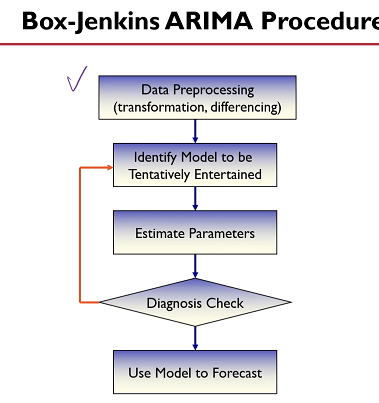

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### STEP 1 : 시계열 데이터 준비  
<b>삼성전자 주식 1년치 가격 데이터 가져오기[2020-05-18 ~ 2021-05-18]</b>  
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다. 여기서는 종가(Close)만 사용해서 시계열 데이터를 생성하겠습니다.  


In [6]:
filepath = '/content/drive/MyDrive/aiffel/data/005930.KS.csv' #삼성전자 데이터 가져오기
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [7]:
df.info() #결측치 없음 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [8]:
ts = df['Close'] #판다스 시리즈 자료형으로 시계열 데이터 생성
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행 & 전처리 과정 중간에 데이터 안정성 확인   
1. 결측치 처리  
df.info()를 통해 결측치 없는 것 확인 했으나 혹시 몰라서 한번더 확인   
2. 로그 변환(정상 시계열 변환)  
그래프를 그려보고 안정성이 없을 경우 적용  
3. trend 제거(정상 시계열 변환)  
trend 확인 될 경우 trend 제거  
4. seasonality 제거(정상 시계열 변환)  
seasonality 확인 될 경우 제거  


### 시계열 안정성(혹은 정상성) 분석  
1. 정성적 그래프 분석  
이동평균 그래프로 그리기    
2. 정량적 Augmented Dicky-Fuller Test  
<b>Augmented Dicky-Fuller Test</b>:데이터의 안정성(stationary)을 테스트하는 통계적 방법, p-value가 0.05미만으로 낮게 나올수록 귀무가설과 관찰된 데이터가 양립한다는 뜻이므로 대립가설을 채택할 수 있다. 여기서 <b>귀무가설은 데이터가 안정적이지 않다는 것</b>이고 귀무가설이 기각되면 해당 데이터가 안정적이다를 채택하는 방법. 즉, p-value가 0.05미만이어야 해당 데이터가 안정적이라고 인정할 수 있다.  
3. 시계열 분해(Time Series Decomposition)  
Residual 안정성 확인  

In [9]:
ts[ts.isna()] #결측치 유무 확인 
#ts.interpolate(method='time') #결측치 보간, 기준은 time => 결측치가 없으므로 보간 할 필요 없음 

Series([], Name: Close, dtype: float64)

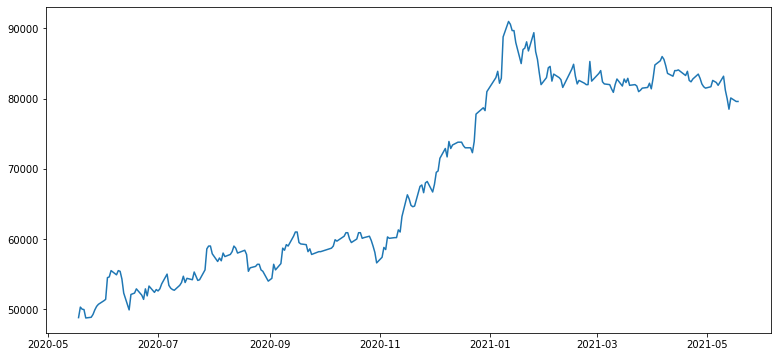

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

In [3]:
#이동평균 그리는 함수 
def plot_rolling_statistics(timeseries, window=12): #window 몇 개의 데이터를 한 묶음으로 이동평균과 이동표준편차를 계산할 건지를 결정 
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original') #원본시계열
    mean = plt.plot(rolmean, color='red', label='Rolling Mean') #평균
    std = plt.plot(rolstd, color='black', label='Rolling Std') #이동표준편차
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)  

이동표준편차는 변화가 없으나 이동평균이 서서히 증가하는 것으로 보아 안정적이지 않은 데이터로 보인다.  

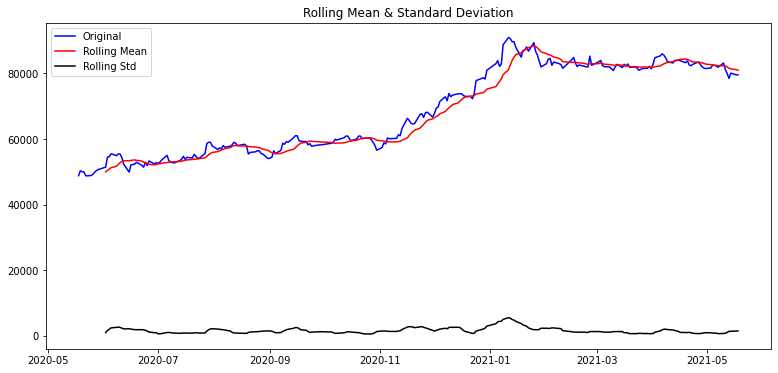

In [11]:
plot_rolling_statistics(ts, window=12)

In [2]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### log 변환
augmented_dickey_fuller_test를 적용한 결과 p-value 값 0.663778은 신뢰수준 보다 너무 높아 이를 낮추는 것이 필요  
=> 로그 변환으로 p-value 값 낮추기  
=> 로그 변환의 결과로 p-value 값이 낮아졌음 0.663778 -> 0.590149  
=> 이동평균선을 그렸을 때도 이동평균과 이동표준편차 선이 아주 약간의 상승은 있지만 거의 일직선으로 나타남  

In [12]:
ts_log = np.log(ts)

In [13]:
augmented_dickey_fuller_test(ts_log) 

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


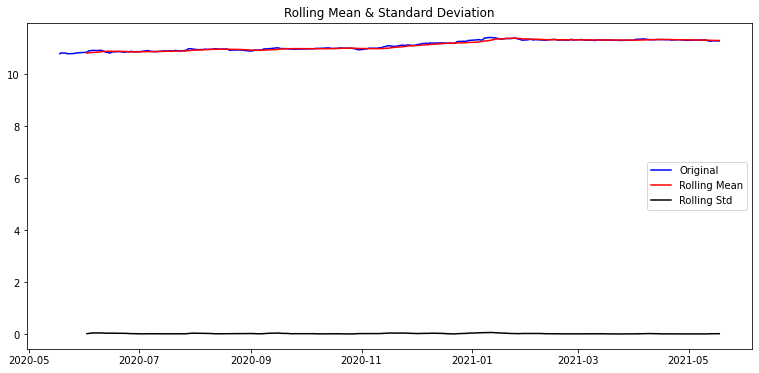

In [14]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

### 시계열 데이터 특성  
<b>시계열 데이터 특성</b>Trend + Seasonality + Cycle + Random(or Residual)  
<b>Level</b>:Level은 Decomposition이 불가능해서 Noise에 속한다.  
<b>Trend</b>:데이터가 장기적으로 증가하거나 감소하는 것이며, 추세가 꼭 선형적일 필요는 없다.  
<b>Seasonality</b>:주, 월, 분기, 반기 단위 등 특정 시간의 주기로 나타나는 패턴  
<b>Cycle</b>:경기변동과 같이 정치, 경제, 사회적 요인에 의한 변화로, 일정 주기가 없으며 장기적인 변화 현상  
<b>Random/Residual</b>:설명될 수 없는 요인 또는 돌발적인 요인에 의하여 일어나는 변화로, 예측 불가능한 임의의 변동을 의미한다. 분해법에서는 원래 데이터에서 추세, 순환, 계절성은 뺀 나머지를 불규칙 요소라 한다.  


<b>statsmodels 패키지의 seasonal_decompose 함수는 seasonal 데이터의 트렌드와 주기성을 살펴보는데 사용한다.</b>  
<b>decomposition</b>은 덧셈 분해와 곱셈 분해가 있다. 덧셈 분해와 곱셈 분해의 차이점은 덧셈 분해는 Trend와 Seasonal이 별개이고, 곱셈 분해는 Trend와 Seasonal이 변화한다고 보면 된다.  
1. <b>덧셈 분해(additive decomposition)</b>: y_t = S_t + T_t + R_t  
여기서 y_t는 데이터, t는 시점, S_t는 계절성분, T_t는 추세 및 순환 성분, R_t는 불규칙 요소를 의미한다.  
2. <b>곱셈 분해(multiplicative decomposition)</b>: y_t = S_t * T_t * R_t  
multiplicative 모델을 활용하려면 데이터에 0이 존재해서는 안된다.  
  
[Reference link](https://leedakyeong.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%ED%95%B4%EB%9E%80Time-Series-Decomposition-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D%EC%9D%B4%EB%9E%80-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%80-%EC%B6%94%EC%84%B8Trend-%EC%88%9C%ED%99%98Cycle-%EA%B3%84%EC%A0%88%EC%84%B1Seasonal-%EB%B6%88%EA%B7%9C%EC%B9%99-%EC%9A%94%EC%86%8CRandom-Residual)



---


● <b>해당 데이터를 덧셈 분해와 곱셈 분해 모두 그려본 결과 육안으로 보기에 동일한 결과가 나와 둘 중 어느 방법을 사용해도 무방하다.</b>  
● 삼성전자 주가는 한달 반의 간격으로 강한 계절성을 보이고 추세가 점진적으로 증가하는 것으로 보인다.   

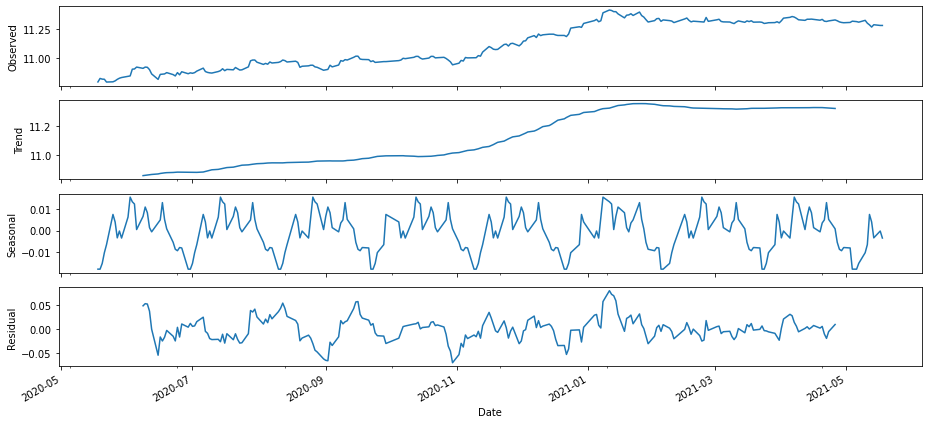

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model="additive", freq=30) #period를 인수로 받지 못해 오류가 계속나서 freq로 바꿨습니다
decomposition.plot()
plt.show()

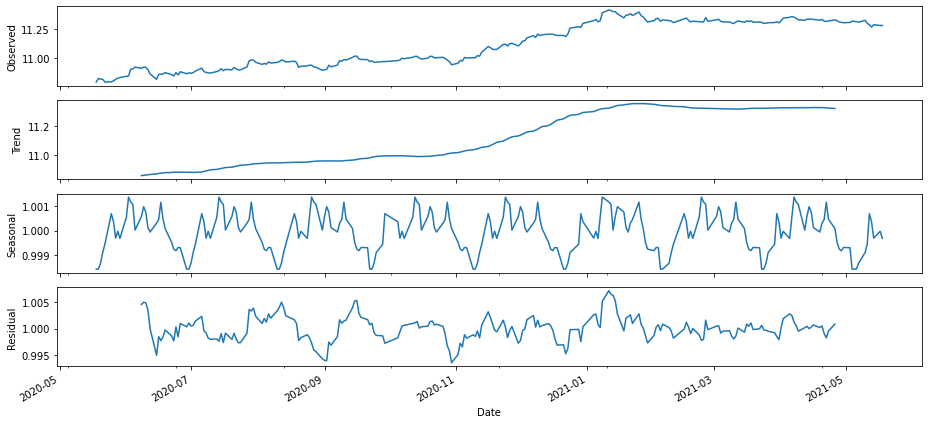

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model="multiplicative", freq=30) #period를 인수로 받지 못해 오류가 계속나서 freq로 바꿨습니다
decomposition.plot()
plt.show()

### 차분(differencing)  
● 안정적이지 않은 데이터를 안정적으로 만드는 방법으로 연이은 관측값들의 차이를 계산하는 것   
● 로그 변환이 시계열 데이터의 분산 변화를 일정하게 만드는데 도움이 되는  
반면, <b>차분은 시계열 데이터의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 하는데 도움이 될 수 있고 추세나 계절성이 제거 또는 감소 될 수 있다.</b>  
● 대부분의 데이터는 2차 차분까지 했을 때 웬만하면 안정적인 데이터를 보인다.  
  
[Reference link](https://velog.io/@cha-suyeon/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%95%EC%83%81%EC%84%B1Stationarity-%EC%B0%A8%EB%B6%84differencing-%ED%99%95%EB%A5%A0%EB%B3%B4%ED%96%89-2%EC%B0%A8-%EC%B0%A8%EB%B6%84)


### Trend 제거(1차 차분) 
로그 변환된 데이터에서 이동평균을 빼서 trend를 제거  

In [17]:
#trend 제거
moving_avg = ts_log.rolling(window=12).mean()
remove_trend = ts_log - moving_avg
remove_trend.head(15) #11개 NaN 값 확인 

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [18]:
remove_trend.dropna(inplace=True) #결측치 제거
remove_trend[remove_trend.isna()] #결측치 확인 

Series([], Name: Close, dtype: float64)

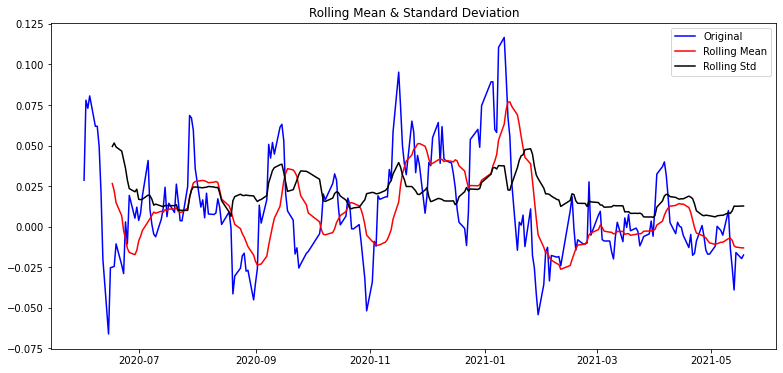

In [19]:
plot_rolling_statistics(remove_trend)

In [20]:
augmented_dickey_fuller_test(remove_trend) 

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


### 계절성 제거(계절성 차분) 및 안정성 확인
앞서 주가 데이터에 계절성을 확인했으므로 계절성도 제거한다.  
추세를 제거한 데이터에서 시계열을 한 스텝 옮긴 데이터를 빼준다.

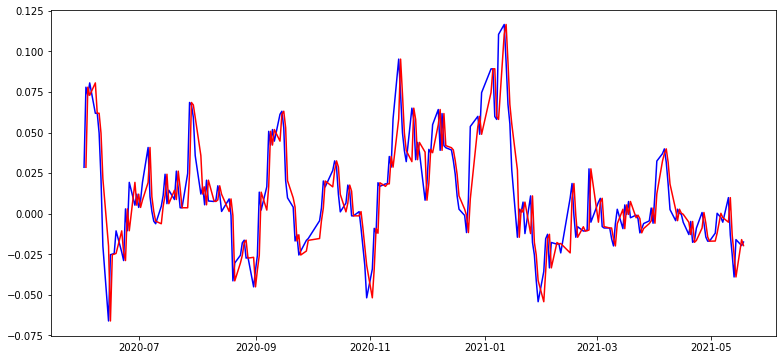

In [21]:
#한 스텝 이동 
remove_trend_shift = remove_trend.shift()

plt.plot(remove_trend, color='blue')
plt.plot(remove_trend_shift, color='red')

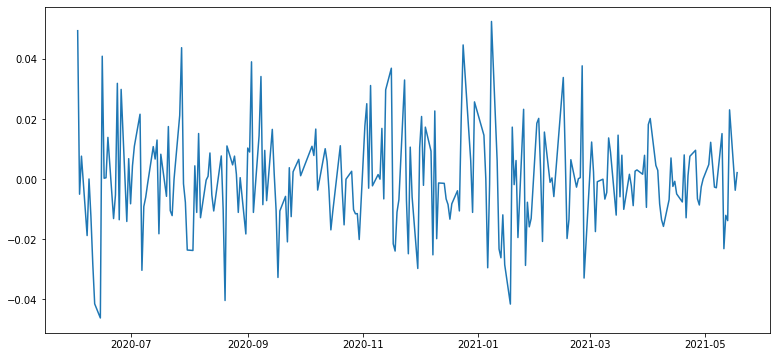

In [22]:
#계절성 차분 
differencing = remove_trend - remove_trend_shift

#결측치 제거 
differencing.dropna(inplace=True)

plt.plot(differencing)

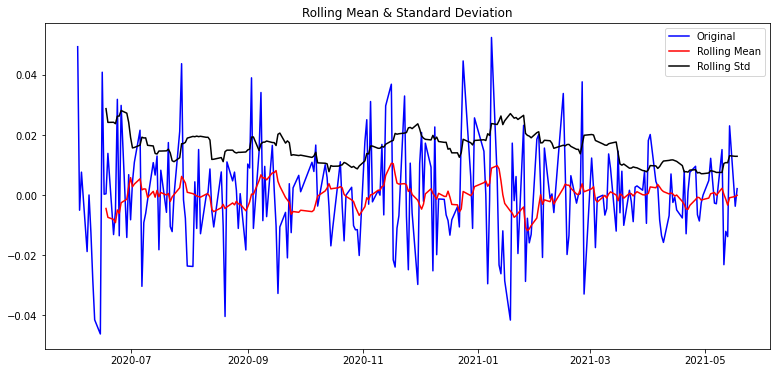

In [23]:
plot_rolling_statistics(differencing, window=12) #정성적 그래프 

### Residual 안정성 확인  
●p-value=2.711476e-28 값이면 충분히 0에 가까우므로 데이터가 안정적이지 않다는 귀무가설을 기각하고 데이터가 안정적이다는 대립가설을 채택합니다.  residual을 가지고 학습과 테스트 데이터를 분리합니다.

In [24]:
augmented_dickey_fuller_test(differencing) 

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성  
ts_log 데이터를 가지고 학습, 테스트 데이터 생성  
train_data와 test_data는 9:1 비율로 분리한다.  

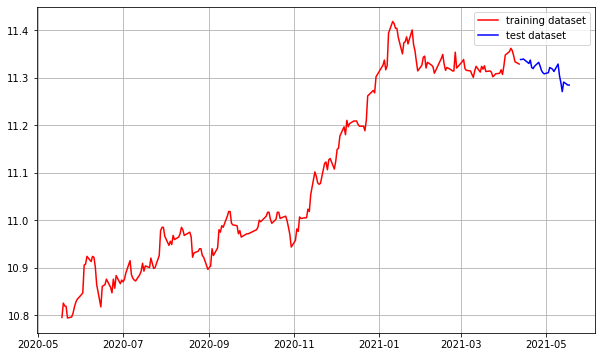

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA Model  
● AR(Auto Coreelation):자기상관성을 시계열 모형으로 구성하였으며, 예측하고자 하는 특정 변수의 과거 관측값의 선형결합으로 해당 변수의 미래값을 예측하는 모형, 이전 관측값이 이후의 관측값에 영향을 준다는 아이디어에 기반  

AR(p) 모형식  

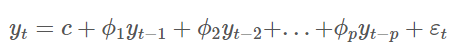
  
● MA(Moving Average) 모형: 예측 오차를 이용하여 미래를 예측하는 모형이다.  
  
MA(q) 모형 식  

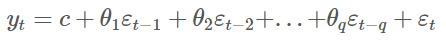  
  
● ARIMA(Autoregressive Integrated Moving Average):AR 모형과 MA 모형을 합친 모형, ARIMA 모형은 시계열 데이터의 정상성(Stationary)를 가정하고 있다. ARIMA의 모수 p는 AR 부분의 차수, d는 차분 횟수, q는 MA 부분의 차수이다. 따라서 AR(p) 모형과 ARIMA(p,0,0) 모형은 같고 MA(q)와 ARIMA(0,0,q)은 같은 모형이다. p와 q는 ACR 그래프와 PACF 그래프를 그려서 확인한다. 이에 대한 설명은 아래에 하겠다.  
  
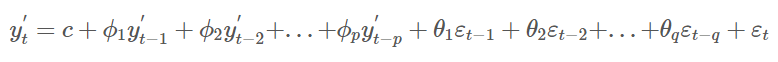  
  
[Reference link](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)

### STEP 5 : 적정 ARIMA 모수 찾기  
● ACF, PACF은 데이터의 정상성을 판단하는데 유용하다. 이 둘을 그려보고 적절한 p,q 구해보자  
● 차분 안정성 확인 -> d 구하기  
●<b>ACF(자기상관함수, AutoCorrelation Function)</b>:시차에 따른 일련의 자기상관을 의미하며, 시차가 커질수록 ACF는 0에 가까워진다. 정상 시계열은 상대적으로 0에 가깝게 수렴하며, 비정상 시계열은 천천히 감소하고, 또는 큰 양의 값을 가진다. ACF를 구하는 식은 일반 Correlation을 구하는 식과 동일하다.  
<b>ACF 구하는 식</b>  
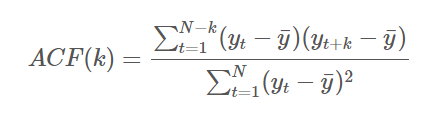  

  
●<b>PACF(편자기상관함수, Partial AutoCorrelation Function)</b>:시차에 따른 일련의 편자기상관이며, 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성이다. y_t와 y_t-k간의 순수한 상관관계로서 두 지점 사이에 포함되는 y_t-1, y_t-2,....,y_t-k+1의 영향은 제거된다.  
<b>PACF 구하는 식</b>  
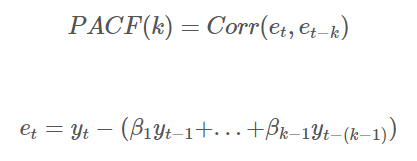
  
<b>ACF와 PACF를 동시에 고려하여 ARIMA의 p와 q를 결정하는 방법</b>  
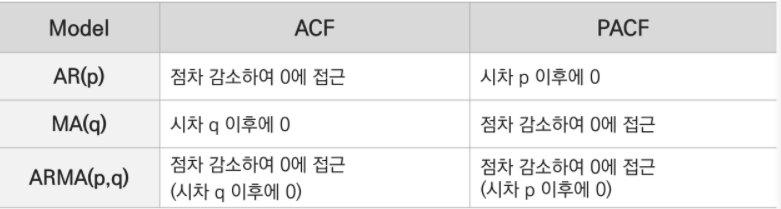



### ACF, PACF 그려보기 -> p,q 구하기

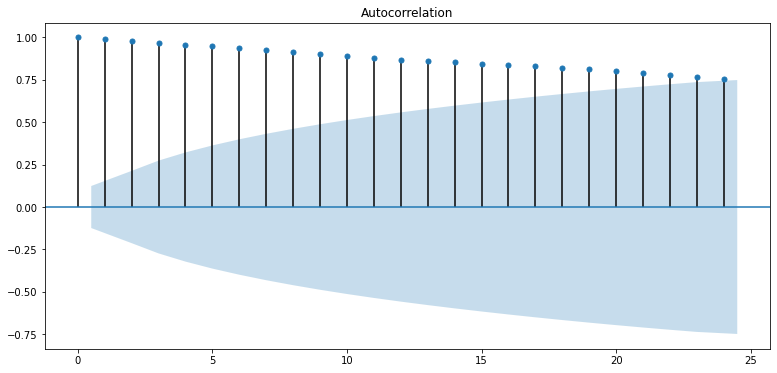

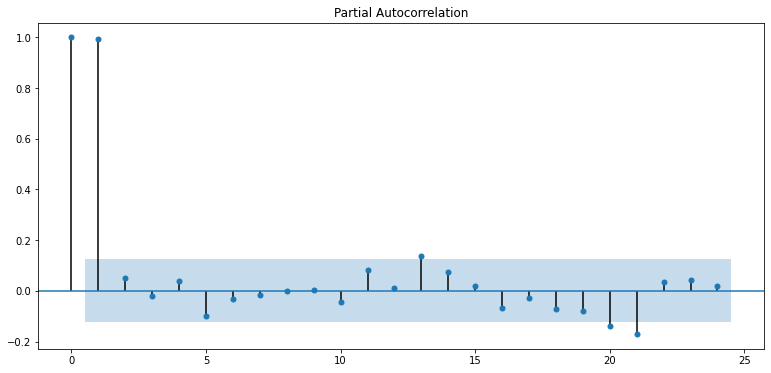

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


●ACF에서 점차 감소하고 있지만 0에 수렴하고 있지는 않아 차분이 필요한 것으로 판단된다.  
●PACF에서 p가 2 이상일 때 값이 0 근처에 있다.  
●아직 그래프를 보고 적정한 p,q 값을 찾는 실력이 안돼 모델 학습시 그리드 서치를 활용하여 적정값을 찾는다.  


### 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


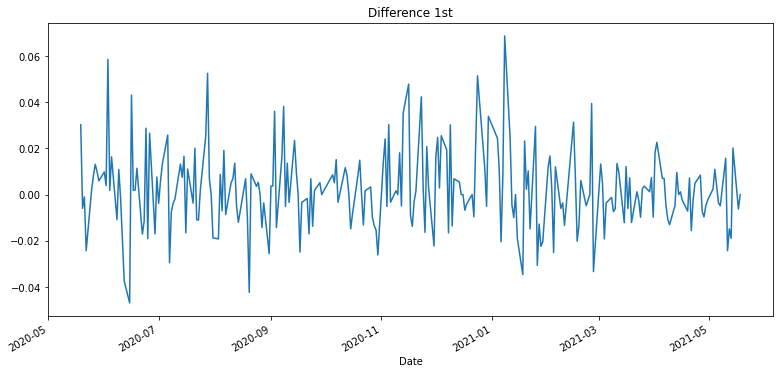

In [27]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

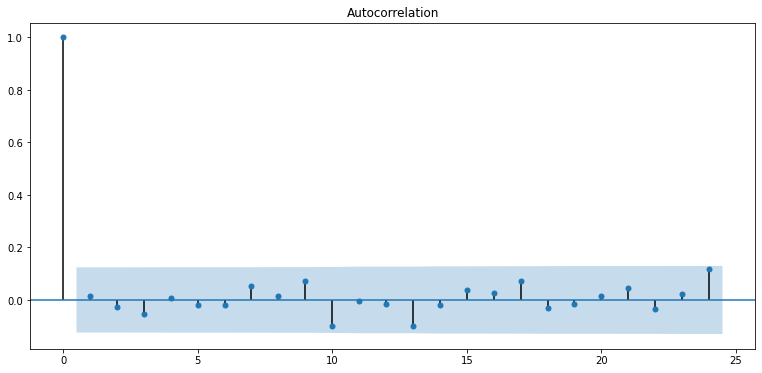

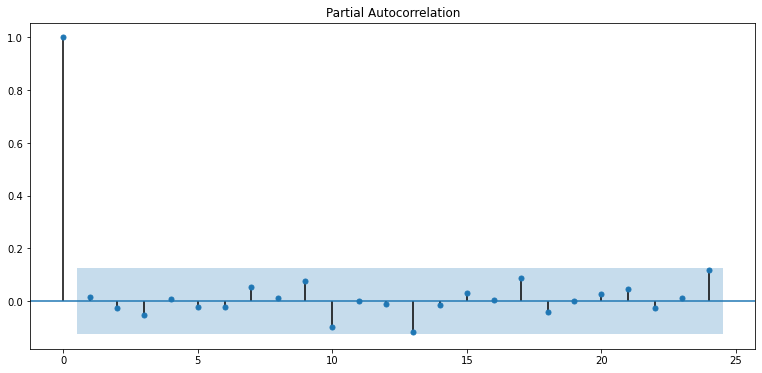

In [28]:
#1차 차분으로 ACF와 PACF 그려보기 
plot_acf(diff_1)  
plot_pacf(diff_1)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


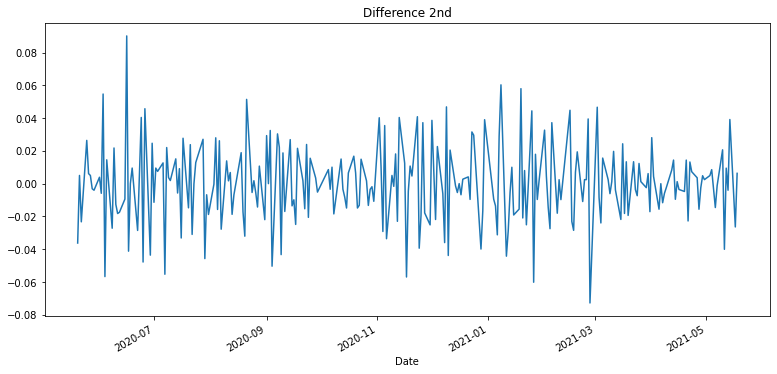

In [29]:
#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

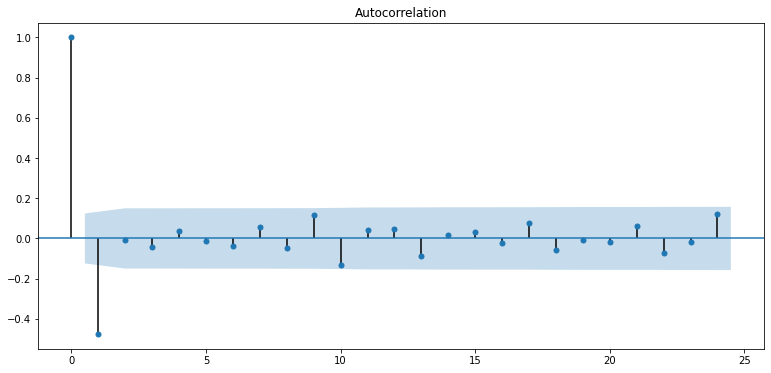

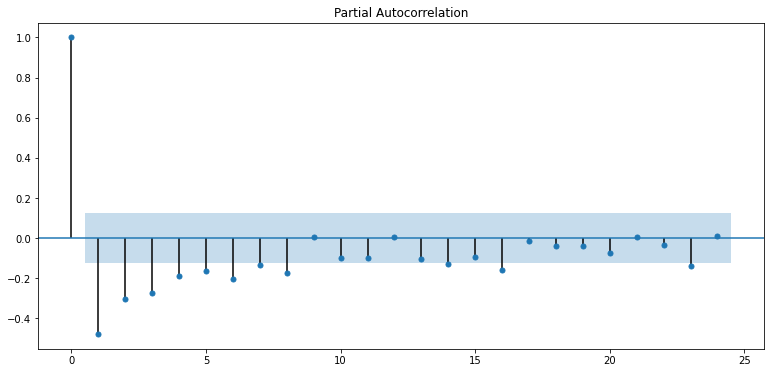

In [30]:
plot_acf(diff_2)  
plot_pacf(diff_2)  
plt.show()

1차 차분과 2차 차분을 모두 해준 결과를 비교하니 1차 차분만으로도 충분해 보인다. 

### STEP 6 : ARIMA 모델 훈련과 테스트  
1. ARIMA 모델 빌드와 훈련  
2. 모델 테스트 및 플로팅  
3. 최종 예측 모델 정확도 측정(MAPE)  

In [31]:
import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

### 그리드 서치
●python은 auto_arima() 함수를 제공하지 않아 그리드 서치 함수를 직접 만들어야 한다.  
[code_reference](https://bluemumin.github.io/adp/2021/03/10/ADP-20%ED%9A%8C-ADP-%EC%8B%A4%EA%B8%B0-python-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D(Arima,-%EC%9E%94%EC%B0%A8%EB%B6%84%EC%84%9D)/)  
   
●<b>AIC(Akaike information criterion)</b>:AIC는 주어진 데이터 셋에 대한 통계 모델의 상대적인 품질을 평가하는 것이다. AIC 값은 낮을수록 좋다.  
AIC = -2ln(L) + 2k  
여기서 -2ln(L)은 모형의 적합도를 의미하며, k는 모형의 추정된 파라미터 개수이다. L은 Likelihood function을 의미한다. AIC 값이 낮다는 것은 모형 적합도가 높은 것을 의미한다.  
  
●그리드 서치의 결과를 보고 가장 낮은 AIC 값이 도출된 모수를 선택한다.  

In [32]:
import warnings #경고 무시 
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore')

def my_auto_arima(data, order, sort='AIC'):
    order_list = [] #pdq 저장
    aic_list = [] #aic 저장
    bic_list = [] #bic 저장 

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q)) #arima model 정의

                try:
                    model_fit = model.fit() #모델 학습 
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic #aic 구하기
                    bic = model_fit.bic #bic 구하기
                    order_list.append(c_order) #리스트에 p,d,q 값 추가
                    aic_list.append(aic) #리스트에 aic 추가
                    bic_list.append(bic) #리스트에 bic 추가
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)), #pdq와 aic 값 가지고 데이터프레임 만들기 
                                         columns=['order', 'AIC']) 
                result_df.sort_values(sort, inplace=True) #aic 값 가장 낮은 순으로 정렬 

    return result_df #데이터프레임 반환


my_auto_arima(train_data, [3, 3, 3])

,order,AIC
3,p0 d1 q0,-1166.729522
4,p0 d1 q1,-1164.795591
12,p1 d1 q0,-1164.791945
19,p2 d1 q0,-1162.974549
5,p0 d1 q2,-1162.954539
20,p2 d1 q1,-1161.443143
9,p1 d0 q0,-1160.933413
10,p1 d0 q1,-1159.214384
16,p2 d0 q0,-1159.210147
11,p1 d0 q2,-1157.221402


그리드 서치 결과 p=0, d=1, q=0 일 때 AIC 수치가 가장 낮았다.  

In [33]:
# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 585.365
Method:                           css   S.D. of innovations              0.018
Date:                Wed, 16 Feb 2022   AIC                          -1166.730
Time:                        23:31:47   BIC                          -1159.906
Sample:                             1   HQIC                         -1163.975
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.010      0.046    5.92e-05       0.005


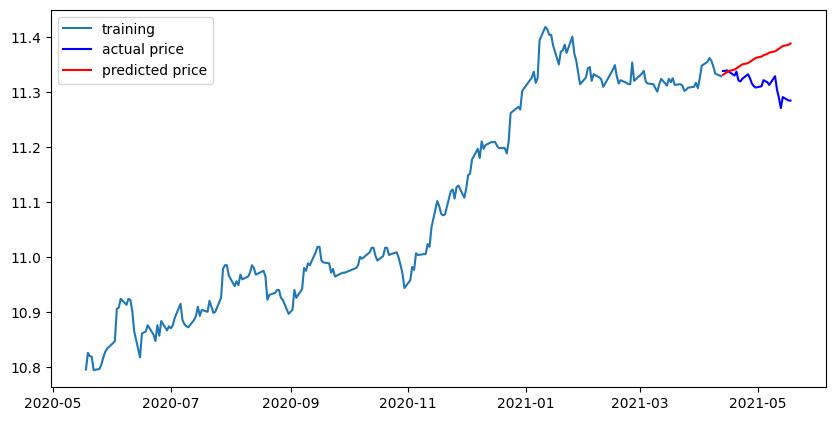

In [34]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  


fc_series = pd.Series(fc, index=test_data.index)   
lower_series = pd.Series(conf[:, 0], index=test_data.index)  
upper_series = pd.Series(conf[:, 1], index=test_data.index)  

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


### ARIMA 모형의 정확도 측정  
●ARIMA 모형의 추정을 통한 예측의 정확도는 mse, mae, rmse, mape로 결정한다.  
●여기서는 mape 15% 미만을 기준으로 정했다.  
mape는 이상치(outlier)에 대한 민감도가 낮고 다른 예측도 평가지표 보다 상대적으로 신뢰도가 높은 이유에서다.  
주가 처럼 예측하기 어려운 데이터는 다른 데이터 보다 상대적으로 이상치가 많을 수 있어 이러한 지표를 선택한게 아닐까 싶다.

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def metrics(data, fc): #평가지표 함수 
  mse = mean_squared_error(np.exp(data), np.exp(fc))
  print('MSE: ', mse)

  mae = mean_absolute_error(np.exp(data), np.exp(fc))
  print('MAE: ', mae)

  rmse = math.sqrt(mean_squared_error(np.exp(data), np.exp(fc)))
  print('RMSE: ', rmse)

  mape = np.mean(np.abs(np.exp(fc) - np.exp(data))/np.abs(np.exp(data)))
  print('MAPE: {:.2f}%'.format(mape*100))

metrics(test_data, fc)

MSE:  22147137.751086995
MAE:  3797.696275515896
RMSE:  4706.074558598386
MAPE: 4.69%


### Result & Discussion
최종결과 MAPE는 4.69%가 나왔는데 그래프를 보니 예측 가격이 발산한다. 응??   
코로나로 주가가 확 내려 앉았다가 급 상승했으니 2020년 중반에서 2021년 중반의 주가 가격이면 한참 주식시장이 좋을 때니 가격이 상승한다고 예측할 법도 하다. 저 시기의 삼성전자라면 십만 전자 가즈아 할 때니까 또 일년치의 데이터면 반도체 시장의 사이클을 반영하지 못한다. 위 예측결과로 현재의 주식가격을 예측할 수 없다는 게 내 생각이다. 애초에 지금의 주식시장을 반영하지 못하는 데이터다. 적어도 10년 이상은 필요하지 않을까? 흑... 인공지능으로 주가 예측이 불가능 할 것이란 의견이 많던데 그 말이 맞는 것 같기도 하다.  
더구나 머신러닝에서 주로 사용했던 평가지표 mse가 22147137.751086995의 수치를 보이고 있으니 MAPE가 낮게 나왔다고 좋아할 일은 아닐 것이다. 많은 발전이 필요하다.  

### STEP 7 : 다른 주식 종목 예측해 보기  
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기  

### 2.두번째 종목(마이크로소프트)   
두 번째 종목은 미국 주식의 대장주 마이크로소프트의 10년치 데이터를 가져와봤다. [2012-02-15 ~ 2022-02-15]  
10년치 데이터는 주가를 얼마나 정확하게 예측할 수 있을지 알아보자  

### 2-1.데이터 가져오기 

In [36]:
MSFT_filepath = '/content/drive/MyDrive/aiffel/data/MSFT.csv' #삼성전자 데이터 가져오기
data = pd.read_csv(MSFT_filepath, index_col='Date', parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-02-16,30.309999,31.549999,30.299999,31.290001,25.493097,94705100
2012-02-17,31.200001,31.320000,30.950001,31.250000,25.460510,70036500
2012-02-21,31.180000,31.610001,31.150000,31.440001,25.615307,50829900
2012-02-22,31.450001,31.680000,31.180000,31.270000,25.476805,49253200
2012-02-23,31.200001,31.590000,31.000000,31.370001,25.558273,35034700


### 2-2.시계열 데이터 생성, 종가만 사용

In [37]:
msft_ts = data['Close'] #판다스 시리즈 자료형으로 시계열 데이터 생성, 종가만 사용
print(type(msft_ts))
msft_ts.head()

<class 'pandas.core.series.Series'>


Date
2012-02-16    31.290001
2012-02-17    31.250000
2012-02-21    31.440001
2012-02-22    31.270000
2012-02-23    31.370001
Name: Close, dtype: float64

### 2-3.데이터 전처리 및 안정성 확인

### 결측치 확인

In [38]:
msft_ts[msft_ts.isna()] #결측치 확인 

Series([], Name: Close, dtype: float64)

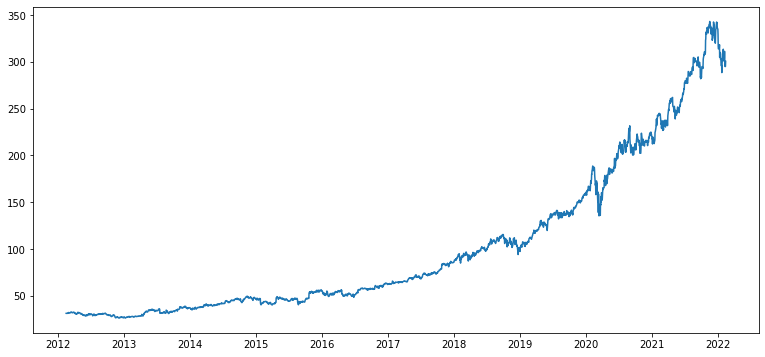

In [39]:
#데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   

plt.plot(msft_ts) 

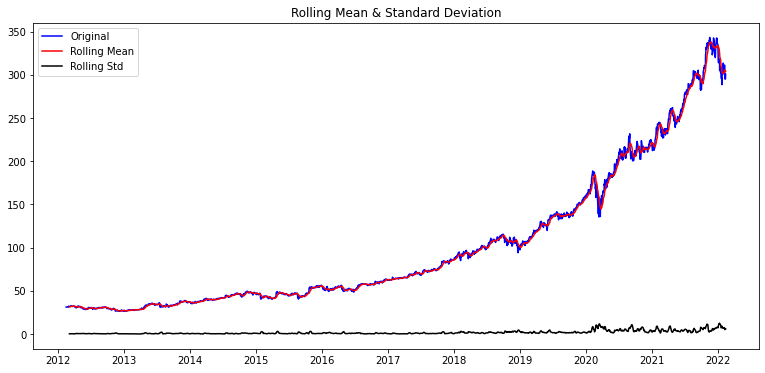

In [40]:
plot_rolling_statistics(msft_ts, window=12)

이동평균은 상승하는데 반에 이동표준편차는 거의 안정적이다.  
아직은 정상성 데이터로 보기 어렵다.  
따라서 귀무가설은 "마이크로소프트 주가 데이터는 안정적이지 않은 데이터"이다.  
안정성 있는 데이터로 만들어보자  

### 로그 변환 

In [41]:
msft_ts_log = np.log(msft_ts) #log 변환 
augmented_dickey_fuller_test(msft_ts_log) 

Results of Dickey-Fuller Test:
Test Statistic                    0.856944
p-value                           0.992502
#Lags Used                       15.000000
Number of Observations Used    2501.000000
Critical Value (1%)              -3.432967
Critical Value (5%)              -2.862696
Critical Value (10%)             -2.567386
dtype: float64


로그변환 결과 p-value 0.992502가 나온 것으로 보아 차분을 해야겠다.  

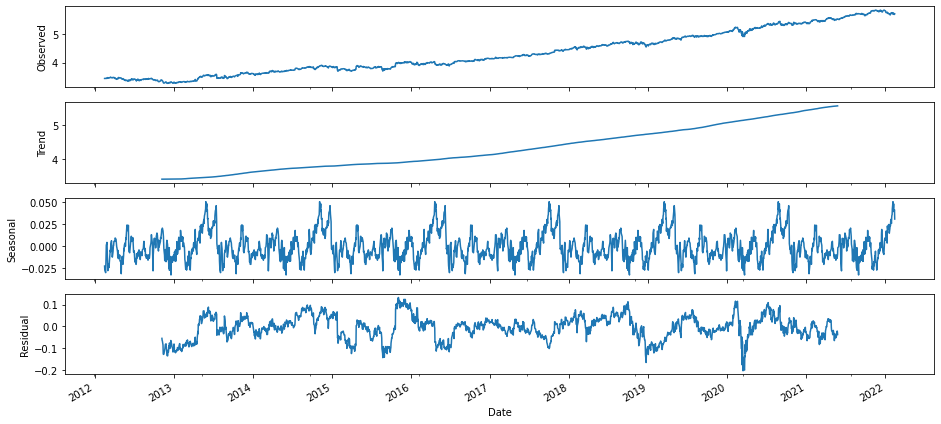

In [42]:
decomposition = seasonal_decompose(msft_ts_log,model="additive", freq=365) 
decomposition.plot()
plt.show()

seasonal_decompose를 활용해 그래프를 그리니 주가가 계속 상승하는 trend가 있었고 1년 반 정도의 주기로 계절성이 있음을 확인했다.  


### trend 제거 

In [43]:
#trend 제거
msft_moving_avg = msft_ts_log.rolling(window=12).mean()
remove_msft_trend = msft_ts_log - msft_moving_avg
remove_msft_trend.head(15)

Date
2012-02-16         NaN
2012-02-17         NaN
2012-02-21         NaN
2012-02-22         NaN
2012-02-23         NaN
2012-02-24         NaN
2012-02-27         NaN
2012-02-28         NaN
2012-02-29         NaN
2012-03-01         NaN
2012-03-02         NaN
2012-03-05    0.006285
2012-03-06   -0.002007
2012-03-07    0.005267
2012-03-08    0.009095
Name: Close, dtype: float64

In [44]:
remove_msft_trend.dropna(inplace=True) #결측치 제거
remove_msft_trend[remove_msft_trend.isna()]

Series([], Name: Close, dtype: float64)

In [45]:
augmented_dickey_fuller_test(remove_msft_trend) #p-value 충분히 낮게 나옴 

Results of Dickey-Fuller Test:
Test Statistic                -1.124052e+01
p-value                        1.811889e-20
#Lags Used                     1.700000e+01
Number of Observations Used    2.488000e+03
Critical Value (1%)           -3.432981e+00
Critical Value (5%)           -2.862702e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


### 계절성 제거 & 시각화
seasonal_decompose를 통해 계절성을 확인했기 때문에 제거해줍니다.  

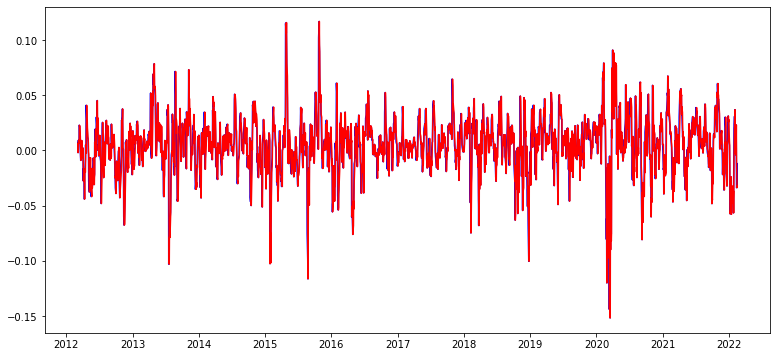

In [46]:
#한 스텝 이동 => 스텝이동한 것과 기존 데이터가 겹쳐보임 
remove_msft_trend_shift = remove_msft_trend.shift()

plt.plot(remove_msft_trend, color='blue')
plt.plot(remove_msft_trend_shift, color='red')

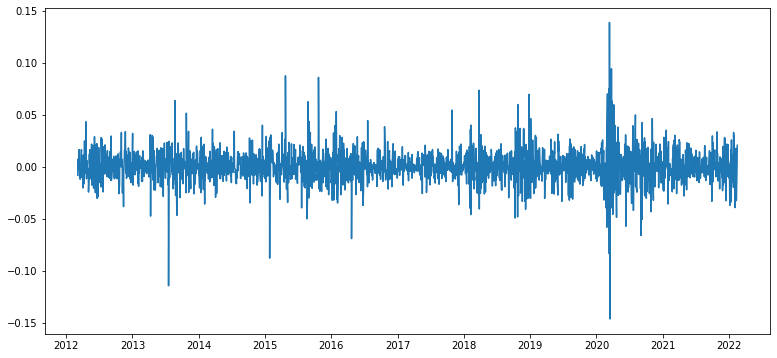

In [47]:
#계절성 차분 
msft_differencing = remove_msft_trend - remove_msft_trend_shift

#결측치 제거 
msft_differencing.dropna(inplace=True)

plt.plot(msft_differencing)

### Residual 안정성 확인  
p-value가 4.868957e-29로 충분히 낮아 데이터가 안정적이지 않다는 귀무가설을 기각하고 대립가설을 채택하여 안정성이 있는 데이터 임을 확인했다.

In [48]:
augmented_dickey_fuller_test(msft_differencing) #residual 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.612355e+01
p-value                        4.868957e-29
#Lags Used                     2.500000e+01
Number of Observations Used    2.479000e+03
Critical Value (1%)           -3.432991e+00
Critical Value (5%)           -2.862707e+00
Critical Value (10%)          -2.567391e+00
dtype: float64


### 2-4.학습 데이터 & 테스트 데이터 분리  
학습 데이터와 테스트 데이터를 9:1로 분리한다.  

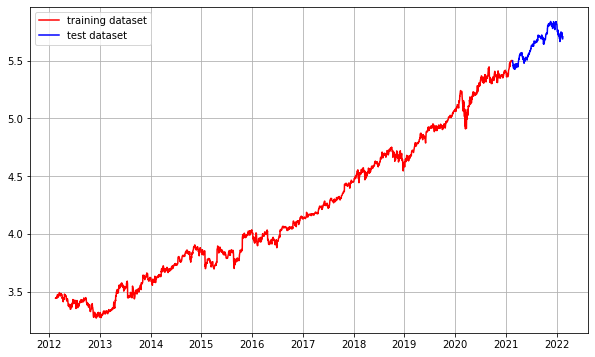

In [50]:
train, test = msft_ts_log[:int(len(msft_ts_log)*0.9)], msft_ts_log[int(len(msft_ts_log)*0.9):] #로그 변환한 데이터를 학습 데이터와 테스트 데이터로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test, c='b', label='test dataset')
plt.legend()

### 2-5.모수 찾기

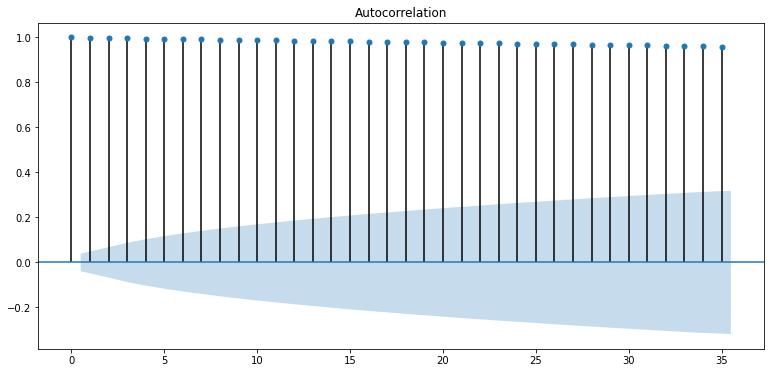

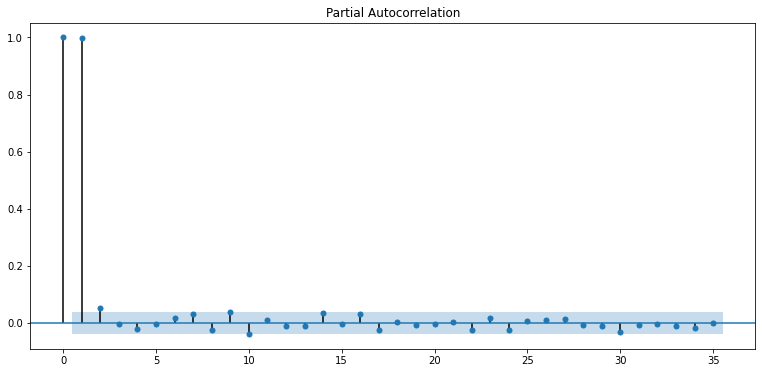

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(msft_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(msft_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

●ACF로 봤을 때 값이 서서히 감소하지 않고 coefficient 값이 0으로 뚝 떨어지지 않아 안정적이다고 볼 수 없다.  
●PACF 그래프에서 coefficient 값이 lag 2부터 0에 수렴함다.  
●ACF와 PACF만 봐서는 p,q 값을 결정할 수 없어 아래서 그리드 서치를 통해 결정한다.  

### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.392080e+01
p-value                        5.300259e-26
#Lags Used                     1.400000e+01
Number of Observations Used    2.501000e+03
Critical Value (1%)           -3.432967e+00
Critical Value (5%)           -2.862696e+00
Critical Value (10%)          -2.567386e+00
dtype: float64


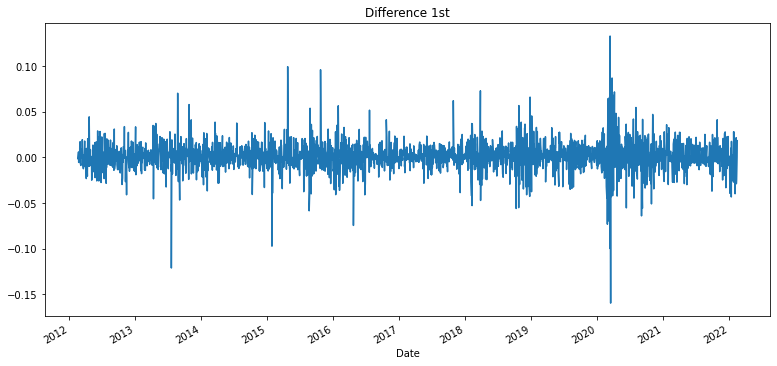

In [52]:
# 1차 차분 구하기
msft_diff_1 = msft_ts_log.diff(periods=1).iloc[1:]
msft_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(msft_diff_1)

### 2차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.626091e+01
p-value                        3.566611e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.487000e+03
Critical Value (1%)           -3.432982e+00
Critical Value (5%)           -2.862703e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


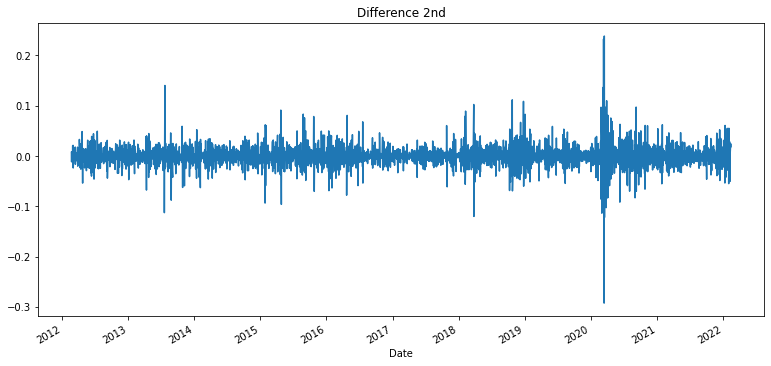

In [53]:
#2차 차분 구하기
msft_diff_2 = msft_diff_1.diff(periods=1).iloc[1:]
msft_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(msft_diff_2)

1차 차분과 2차 차분의 결과를 보아 1차 차분만으로도 충분히 귀무가설을 기각하고 안정적인 데이터를 보인다.  

### 그리드 서치를 통한 모수 찾기

In [60]:
my_auto_arima(train, [10, 3, 10])

,order,AIC
107,p6 d1 q3,-12306.999514
146,p8 d1 q5,-12305.862671
108,p6 d1 q4,-12305.272940
125,p7 d1 q3,-12305.228000
58,p3 d1 q6,-12304.560179
...,...,...
4,p0 d0 q4,-4731.469390
3,p0 d0 q3,-3425.812459
2,p0 d0 q2,-1283.608835
1,p0 d0 q1,1205.845871


### 2-6 찾은 모수로 한번 더 모델 학습

In [61]:
# Build and Train  Model
msft_model = ARIMA(train, order=(6, 1, 3))  
msft_fitted_m = msft_model.fit() 

print(msft_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(6, 1, 3)   Log Likelihood                6164.500
Method:                       css-mle   S.D. of innovations              0.016
Date:                Wed, 16 Feb 2022   AIC                         -12307.000
Time:                        13:41:44   BIC                         -12244.026
Sample:                             1   HQIC                        -12284.022
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.000      3.682      0.000       0.000       0.001
ar.L1.D.Close    -1.0466      0.129     -8.132      0.000      -1.299      -0.794
ar.L2.D.Close     0.0394      0.223     

### 2-7 forecast

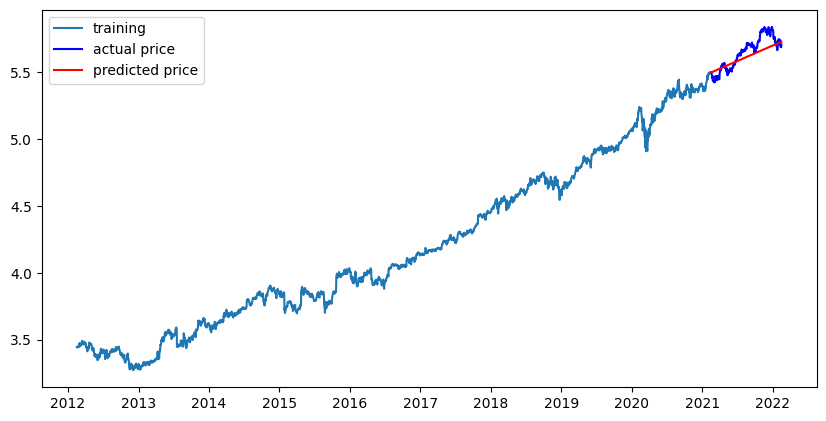

In [62]:
# Forecast : 결과가 fc에 담깁니다. 
msft_fc, msft_se, msft_conf = msft_fitted_m.forecast(len(test), alpha=0.05)  


msft_fc_series = pd.Series(msft_fc, index=test.index)   
msft_lower_series = pd.Series(msft_conf[:, 0], index=test.index)  
msft_upper_series = pd.Series(msft_conf[:, 1], index=test.index)  

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(msft_fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 2-8.MAPE 지표 확인

In [63]:
metrics(test, msft_fc)

MSE:  488.43891594489617
MAE:  17.558526758421173
RMSE:  22.100654197215434
MAPE: 5.87%


### 2-9.Result & Discussion  
후 다행이 그래프를 보면 예측선과 실제 값을 나타낸 선 간에 차이가 별로 없어 보인다. MAPE 값은 삼성전자 케이스 보다 높았지만 그래프를 봤을 때 더 만족스러운 결과가 나왔다. MAPE를 제외한 나머지 세 지표들은 모두 훨씬 낮은 값이 나왔기 때문이다. 아무래도 10년 이상의 데이터가 그 동안의 경제 호황, 경제 위기, 경제 성장률 등 여러 요소를 반영하기 때문에 더 정확한 예측을 하는데 도움을 준 것으로 보인다.  

### 3.세번째 종목 분석 (lululemon)  
마지막으로 분석할 종목은 요가 산업을 주도하고 있는 캐나다 스포츠 의류 브랜드 <b>룰루레몬</b>의 10년 데이터를 분석했다.  
[2012-02-16 ~ 2022-02-16]    


### 3-1.데이터 불러오기

In [36]:
lu_filepath = '/content/drive/MyDrive/aiffel/data/LULU.csv' #삼성전자 데이터 가져오기
lu_data = pd.read_csv(lu_filepath, index_col='Date', parse_dates=True)
lu_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-02-16,64.720001,65.889999,64.150002,65.589996,65.589996,1774600
2012-02-17,65.879997,65.989998,64.769997,65.010002,65.010002,1127100
2012-02-21,65.489998,65.919998,63.919998,64.260002,64.260002,1157600
2012-02-22,63.770000,65.339996,63.490002,65.000000,65.000000,1133600
2012-02-23,64.790001,67.129997,64.790001,66.699997,66.699997,1681900


In [37]:
lu_ts = lu_data['Close'] #판다스 시리즈 자료형으로 시계열 데이터 생성, 종가만 사용
print(type(lu_ts))
lu_ts.head()

<class 'pandas.core.series.Series'>


Date
2012-02-16    65.589996
2012-02-17    65.010002
2012-02-21    64.260002
2012-02-22    65.000000
2012-02-23    66.699997
Name: Close, dtype: float64

### 3-2.데이터 결측치 제거 및 안정성 확인

In [38]:
lu_ts[lu_ts.isna()] #결측치 확인 

Series([], Name: Close, dtype: float64)

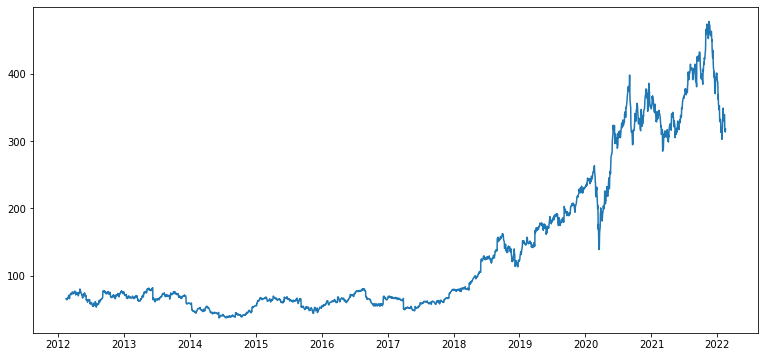

In [39]:
#데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   

plt.plot(lu_ts) 

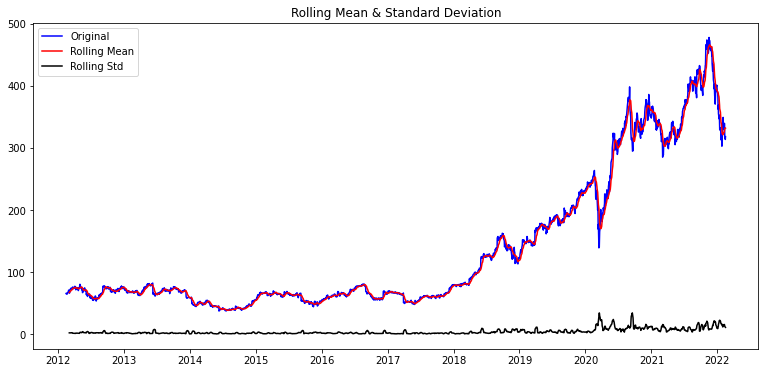

In [40]:
plot_rolling_statistics(lu_ts, window=12)

이동표준편차는 일정하고 이동평균은 상승하는 형태를 보인다,

### 로그변환
p-value 값이 0.949476으로 안정적이지 않은 데이터다. 

In [41]:
lu_ts_log = np.log(lu_ts) #log 변환 
augmented_dickey_fuller_test(lu_ts_log) 

Results of Dickey-Fuller Test:
Test Statistic                   -0.099621
p-value                           0.949476
#Lags Used                        6.000000
Number of Observations Used    2510.000000
Critical Value (1%)              -3.432958
Critical Value (5%)              -2.862692
Critical Value (10%)             -2.567383
dtype: float64


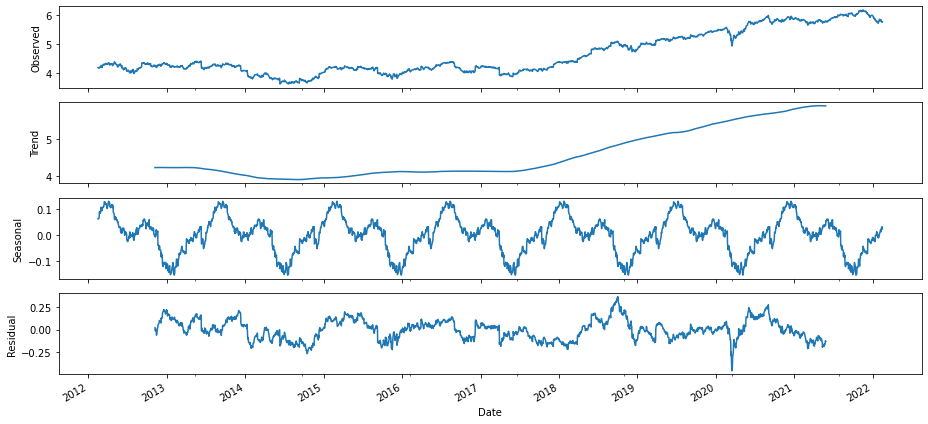

In [42]:
decomposition = seasonal_decompose(lu_ts_log,model="additive", freq=365) #period를 인수로 받지 못해 오류가 계속나서 freq로 바꿨습니다
decomposition.plot()
plt.show()

주가가 상승하는 추세를 보이고 1년 반 주기로 계절성을 보이므로 차분을 통해 p-value 값을 낮춘다. 

In [43]:
#trend 제거
lu_moving_avg = lu_ts_log.rolling(window=12).mean()
remove_lu_trend = lu_ts_log - lu_moving_avg
remove_lu_trend.head(15)

Date
2012-02-16         NaN
2012-02-17         NaN
2012-02-21         NaN
2012-02-22         NaN
2012-02-23         NaN
2012-02-24         NaN
2012-02-27         NaN
2012-02-28         NaN
2012-02-29         NaN
2012-03-01         NaN
2012-03-02         NaN
2012-03-05    0.025482
2012-03-06   -0.016183
2012-03-07    0.018153
2012-03-08    0.042434
Name: Close, dtype: float64

In [44]:
remove_lu_trend.dropna(inplace=True) #결측치 제거
remove_lu_trend[remove_lu_trend.isna()]

Series([], Name: Close, dtype: float64)

In [45]:
augmented_dickey_fuller_test(remove_lu_trend) #안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.073372e+01
p-value                        2.935118e-19
#Lags Used                     1.300000e+01
Number of Observations Used    2.492000e+03
Critical Value (1%)           -3.432977e+00
Critical Value (5%)           -2.862701e+00
Critical Value (10%)          -2.567388e+00
dtype: float64


1차 차분만으로도 p-value 값이 충분히 낮아졌다. 

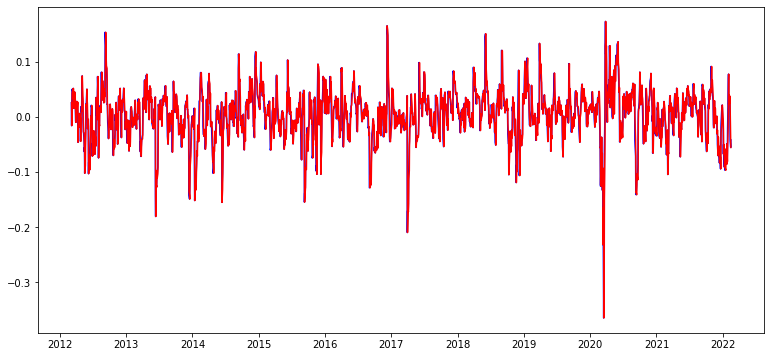

In [46]:
#한 스텝 이동 => 스텝이동한 것과 기존 데이터가 겹쳐보임 
remove_lu_trend_shift = remove_lu_trend.shift()

plt.plot(remove_lu_trend, color='blue')
plt.plot(remove_lu_trend_shift, color='red')

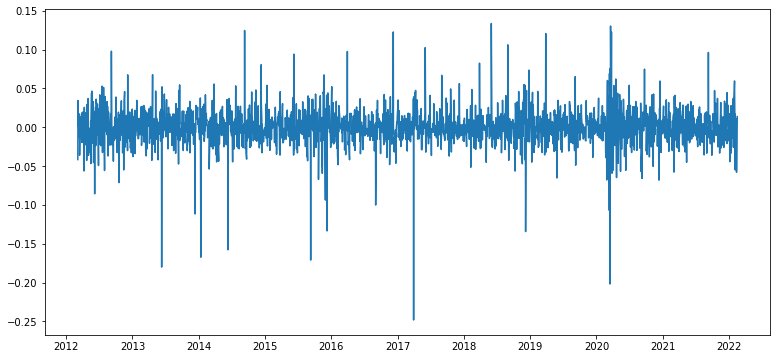

In [47]:
#계절성 차분 
lu_differencing = remove_lu_trend - remove_lu_trend_shift

#결측치 제거 
lu_differencing.dropna(inplace=True)

plt.plot(lu_differencing)

In [48]:
augmented_dickey_fuller_test(lu_differencing) #residual 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -1.476892e+01
p-value                        2.338948e-27
#Lags Used                     2.700000e+01
Number of Observations Used    2.477000e+03
Critical Value (1%)           -3.432993e+00
Critical Value (5%)           -2.862708e+00
Critical Value (10%)          -2.567392e+00
dtype: float64


residual 안정성 확인에서 p-value가 2.338948e-27로 충분히 낮아진 것을 확인했다. 

### 3-3.학습 데이터 테스트 데이터 분리  
학습 데이터와 테스트 데이터는 로그 변환 데이터를 9:1 비율로 분리한다.

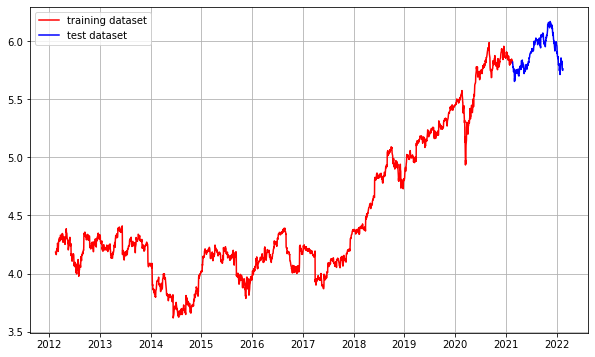

In [49]:
lu_train, lu_test = lu_ts_log[:int(len(lu_ts_log)*0.9)], lu_ts_log[int(len(lu_ts_log)*0.9):] #로그 변환한 데이터를 학습 데이터와 테스트 데이터로 분리
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(lu_train, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(lu_test, c='b', label='test dataset')
plt.legend()

### ACF와 PACF 그래프 그리기

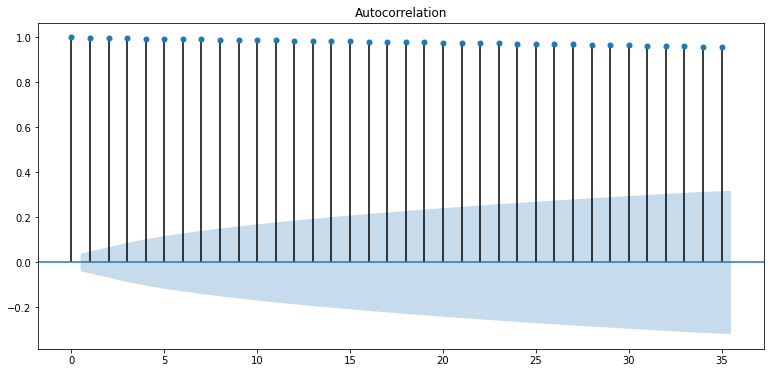

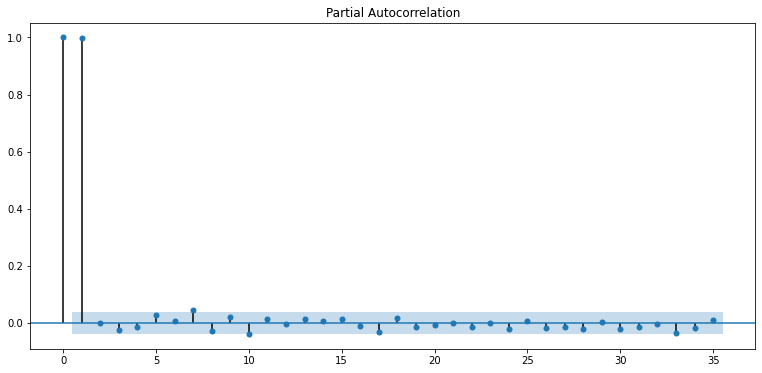

In [50]:
plot_acf(lu_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(lu_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 1차 차분과 2차 차분 

Results of Dickey-Fuller Test:
Test Statistic                  -22.131687
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2510.000000
Critical Value (1%)              -3.432958
Critical Value (5%)              -2.862692
Critical Value (10%)             -2.567383
dtype: float64


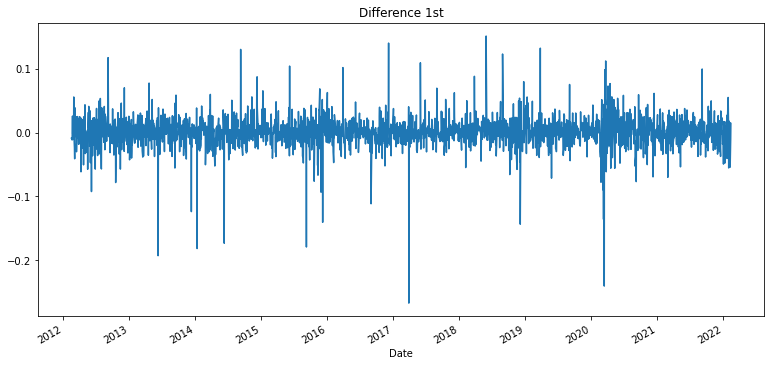

In [51]:
# 1차 차분 구하기
lu_diff_1 = lu_ts_log.diff(periods=1).iloc[1:]
lu_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(lu_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.651269e+01
p-value                        2.098884e-29
#Lags Used                     2.600000e+01
Number of Observations Used    2.488000e+03
Critical Value (1%)           -3.432981e+00
Critical Value (5%)           -2.862702e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


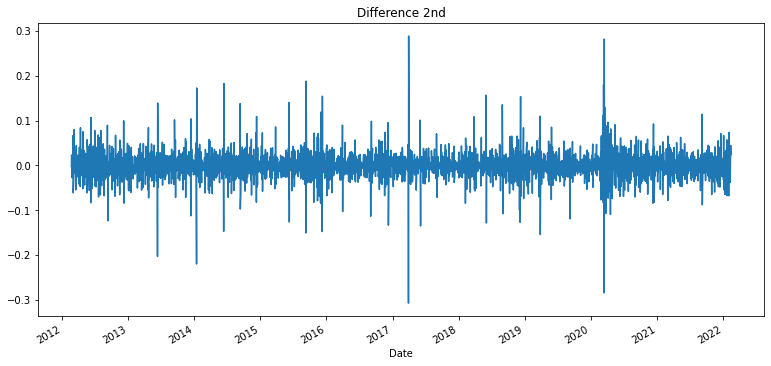

In [52]:
#2차 차분 구하기
lu_diff_2 = lu_diff_1.diff(periods=1).iloc[1:]
lu_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(lu_diff_2)

대부분의 경우와 마찬가지로 1차 차분만으로 p-value 값이 충분히 낮아져 귀무가설을 기각하고 안정적인 데이터로 볼 수 있다. 

### 3-4.모델 학습 및 결과 확인

### 그리드 서치를 통한 모수 찾기 

In [90]:
my_auto_arima(lu_train, [10, 3, 10])

,order,AIC
151,p9 d1 q3,-10298.842425
152,p9 d1 q4,-10296.208796
136,p8 d1 q7,-10295.665967
64,p4 d1 q2,-10292.992222
154,p9 d1 q6,-10292.602447
...,...,...
14,p0 d2 q0,-8717.820384
3,p0 d0 q4,-4453.612660
2,p0 d0 q3,-3206.663555
1,p0 d0 q1,1130.787872


### 찾은 모수로 한번더 학습

In [53]:
# Build and Train  Model
lu_model = ARIMA(lu_train, order=(9, 1, 3))  
lu_fitted_m = lu_model.fit() 

print(lu_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(9, 1, 3)   Log Likelihood                5163.421
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 16 Feb 2022   AIC                         -10298.842
Time:                        23:35:08   BIC                         -10218.694
Sample:                             1   HQIC                        -10269.598
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.534      0.125      -0.000       0.002
ar.L1.D.Close    -0.4104      0.116     -3.527      0.000      -0.638      -0.182
ar.L2.D.Close    -0.4613      0.066     

### 결과 그래프  
기존 그래프와 예측 그래프가 얼마나 비슷한지 확인

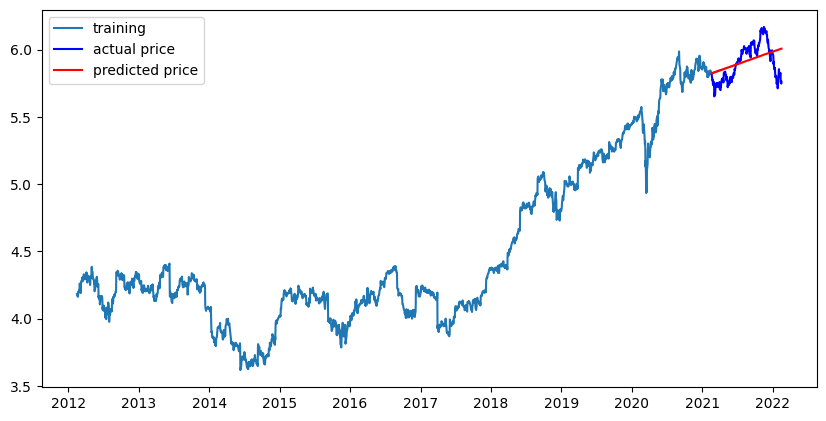

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
lu_fc, lu_se, lu_conf = lu_fitted_m.forecast(len(lu_test), alpha=0.05)  


lu_fc_series = pd.Series(lu_fc, index=lu_test.index)   
lu_lower_series = pd.Series(lu_conf[:, 0], index=lu_test.index)  
lu_upper_series = pd.Series(lu_conf[:, 1], index=lu_test.index)  

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(lu_train, label='training')
plt.plot(lu_test, c='b', label='actual price')
plt.plot(lu_fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 성능 지표 확인

In [55]:
metrics(lu_test, lu_fc)

MSE:  1855.7527106603577
MAE:  36.14350023341881
RMSE:  43.07844833162353
MAPE: 9.84%


### Result&Discussion  
●p와 q 값이 각각 9와 3으로 특히 p값이 높음을 알 수 있었다.  
●결과는 MAPE 값이 9.84%가 나왔다. 룰루레몬의 경우 2018년도 이전에는 주가 변동이 별로 없다가 그 이후에 큰 상승폭을 보였는데 이점이 예측선의 기울기를 완만하게 결정한 것 같다. 그리고 장기적으로 보면 주가는 계속 상승해왔기 때문에 상승하는 예측선이 나온 것 같다. 하지만 예측선이 현재의 주가 시장을 반영하고 있지는 못한다. 최근 우크라이나와 러시아 간의 긴장 상태로 인해 주가가 많이 떨어졌고 언제 다시 상승할지 모르는 상황에서 저 예측선은 너무 긍정적인게 아닐까 싶다.  
●세 종목을 예측해 본 결과 실제로 주가 예측에 사용할만큼의 성능은 나오지 않아 실용적으로 활용하기 위해서는 더 많은 연구가 있어야겠다.   